# FloPy VTK/PyVista particle tracking pathline visualization demo

This notebook arranges and runs a steady state MODFLOW 6 groundwater flow model, then a MODPATH 7 particle tracking model, using the Freyberg grid. Particle tracks are exported to VTK files, then loaded and visualized with [PyVista](https://docs.pyvista.org/version/stable/index.html), first in a static plot and then an animated GIF.

First, import FloPy and show the version.

In [1]:
import sys
import flopy

print(sys.version)
print("flopy version: {}".format(flopy.__version__))

3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
flopy version: 3.3.7


Load the Freyberg MF6 groundwater flow model.

In [2]:
from pathlib import Path
from flopy.mf6 import MFSimulation

mdl_name = "freyberg"
sim_name = f"mf6-{mdl_name}-vtk-pathlines"
sim_path = Path.cwd().parent / "../examples/data" / f"mf6-{mdl_name}"

sim = MFSimulation.load(
    sim_name=sim_name,
    sim_ws=sim_path
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package chd...
    loading package riv...
    loading package wel...
    loading package rch...
  loading solution package freyberg...


Create a temporary directory and change the simulation's workspace.

In [3]:
from tempfile import TemporaryDirectory

temp_path = TemporaryDirectory()
workspace = Path(temp_path.name)
sim.set_sim_path(workspace)

Write the input files to the temporary workspace.

In [4]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package freyberg...
  writing model freyberg...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package chd_0...
    writing package riv_0...
    writing package wel_0...
    writing package rch_0...


Run the groundwater flow simulation.

In [5]:
success, buff = sim.run_simulation(silent=True, report=True)
assert success, "MODFLOW 6 simulation failed"
for line in buff:
    print(line)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthoriz

Define particle release locations. In this example we will release 16 particles, with each particle released at the center of a unique grid cell. Cells containing particle release points are clustered into four 2x2 square regions.

In [6]:
pgs = []
gwf = sim.get_model(mdl_name)

for i in range(1, 5):
    nrow = gwf.modelgrid.nrow
    ncol = gwf.modelgrid.ncol
    m = i * 2 if i < 3 else (nrow - i * 4)
    n = i *2 if i < 3 else (ncol - i * 4)
    celldata = flopy.modpath.CellDataType(
        drape=0,
        columncelldivisions=1,
        rowcelldivisions=1,
        layercelldivisions=1
    )
    lrcpd = flopy.modpath.LRCParticleData(
        subdivisiondata=[celldata],
        lrcregions=[[[0, m, n, 0, m + 1, n + 1]]],
    )
    pg = flopy.modpath.ParticleGroupLRCTemplate(
        particlegroupname=f"PG{i}", particledata=lrcpd, filename=f"{sim_name}.pg{i}.sloc"
    )
    pgs.append(pg)

Retrieve well locations (to define termination zones).

In [7]:
import numpy as np

wel_locs = [(rec[0][1], rec[0][2]) for rec in (gwf.wel.stress_period_data.data[0])]
print(wel_locs)

[(8, 15), (10, 12), (19, 13), (25, 9), (28, 5), (33, 11)]


Define particle termination zones.

In [8]:
zone_maps = []

# zone 1 is the default (non-terminating regions)
def fill_zone_1():
    return np.ones((nrow, ncol), dtype=np.int32)

za = fill_zone_1()
for wl in wel_locs:
    za[wl] = 2  # wells
za[:,14] = 3  # river is in column 14
zone_maps.append(za)

Create a MODPATH 7 simulation forward tracking model in `combined` (pathline & timeseries) mode.

In [9]:
mp = flopy.modpath.Modpath7(
    modelname=f"{sim_name}_mp",
    flowmodel=gwf,
    exe_name="mp7",
    model_ws=workspace,
)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="combined",
    trackingdirection="forward",
    budgetoutputoption="summary",
    referencetime=[0, 0, 0.0],
    timepointdata=[1, [0]],
    zonedataoption="on",
    zones=zone_maps,
    particlegroups=pgs,
)

Write and run the particle tracking model.

In [10]:
mp.write_input()
success, buff = mp.run_model(silent=True, report=True)
assert success, "MODPATH 7 simulation failed"
for line in buff:
    print(line)


MODPATH Version 7.2.001   
Program compiled Aug 01 2021 12:57:00 with IFORT compiler (ver. 19.10.3)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
        16 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


Open the pathline output file and read pathline data.

In [11]:
from flopy.utils import PathlineFile

pf = PathlineFile(workspace / mpsim.pathlinefilename)
pl = pf.get_alldata()

Plot the grid, heads, boundary conditions, and pathlines.

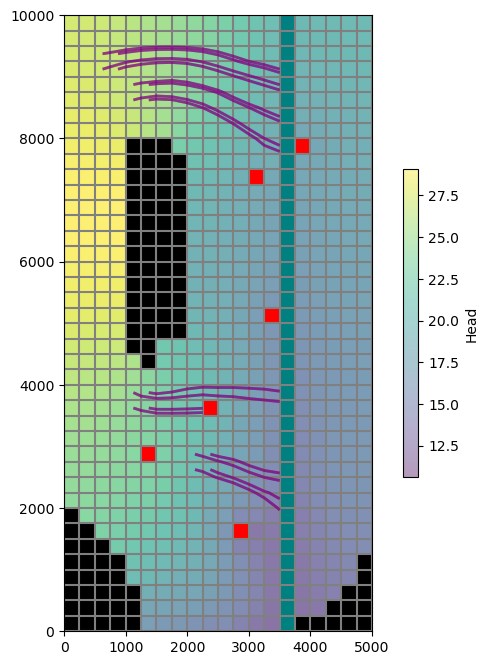

In [12]:
import matplotlib.pyplot as plt

hf = flopy.utils.HeadFile(workspace / f"{mdl_name}.hds")
hds = hf.get_data()
        
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mv = flopy.plot.PlotMapView(model=gwf)
mv.plot_grid()
mv.plot_ibound()
hd = mv.plot_array(hds, alpha=0.4)
cb = plt.colorbar(hd, shrink=0.5)
cb.set_label("Head")
mv.plot_bc("RIV")
mv.plot_bc("WEL", plotAll=True)
mv.plot_pathline(pl, layer="all", alpha=0.5, colors=["purple"], lw=2)
plt.show()

Create a `Vtk` object and add the flow model outputs and pathlines.

In [13]:
from flopy.export.vtk import Vtk

vtk = Vtk(model=gwf, binary=False, vertical_exageration=50, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(pl)

Convert the VTK object to PyVista meshes.

In [14]:
grid, pathlines = vtk.to_pyvista()

Rotate the meshes to match the orientation of the map view plot above.

In [15]:
import pyvista as pv

axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

grid.rotate_z(160, point=axes.origin, inplace=True)
pathlines.rotate_z(160, point=axes.origin, inplace=True)

UnstructuredGrid (0x1b6a233a0)
  N Cells:    223
  N Points:   207
  X Bounds:   -6.410e+03, -2.297e+03
  Y Bounds:   -8.596e+03, -6.525e+02
  Z Bounds:   3.392e+02, 1.160e+03
  N Arrays:   2

Check some grid properties to make sure the export succeeded.

In [16]:
assert grid.n_cells == gwf.modelgrid.nnodes
print("Model grid has", grid.n_cells, "cells")
print("Model grid has", grid.n_arrays, "arrays")

Model grid has 800 cells
Model grid has 9 arrays


Select particle release locations and build a dictionary of particle tracks (pathlines). This will be used below for particle labelling, as well as for animation.

**Note**: while below we construct pathlines manually from data read from the exported VTK files, pathlines may also be read directly from the MODPATH 7 pathline output file (provided the simulation was run in `pathline` or `combined` mode, as this one was).

In [17]:
tracks = {}
particle_ids = set()
release_locs = list()

for i, t in enumerate(pathlines["time"]):
    pid = str(round(float(pathlines["particleid"][i])))
    loc = pathlines.points[i]

    if pid not in tracks:
        tracks[pid] = []
        particle_ids.add(pid)
        release_locs.append(loc)
    
    # store the particle location in the corresponding track
    tracks[pid].append((loc, t))

release_locs = np.array(release_locs)
tracks = {k: np.array(v, dtype=object) for k, v in tracks.items()}
max_track_len = max([len(v) for v in tracks.values()])
print("The maximum number of locations per particle track is", max_track_len)

The maximum number of locations per particle track is 18


View the grid and pathlines with PyVista, with particle tracks/locations colored by time. Also add particle ID labels to a few particles' release locations.

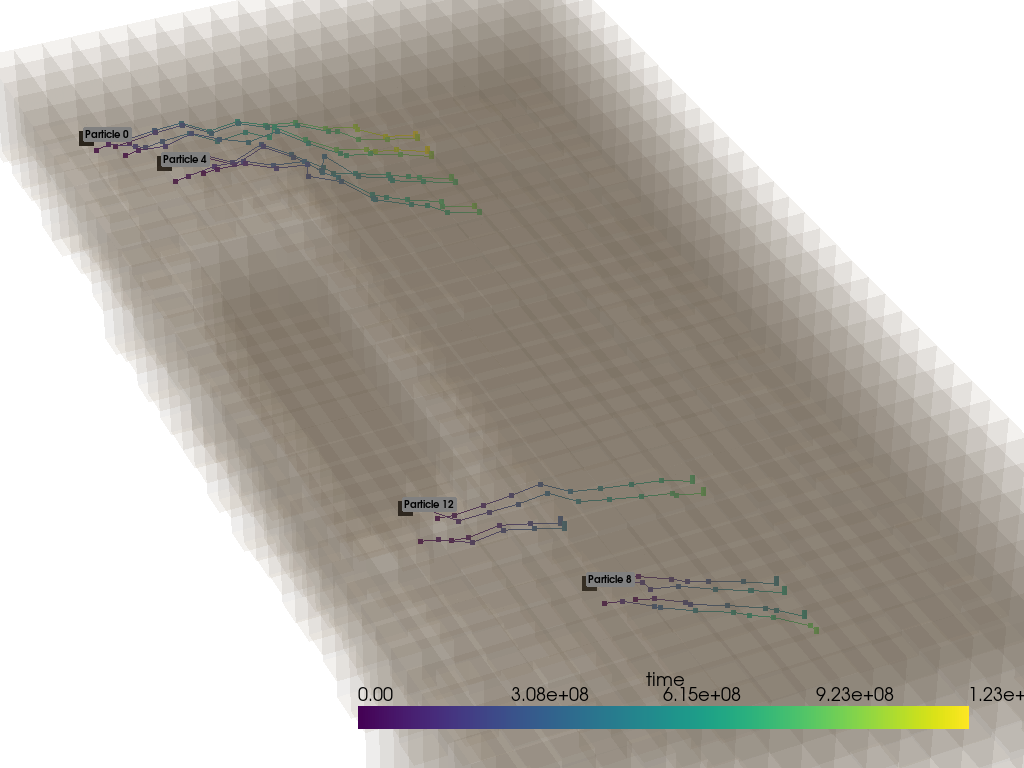

In [18]:
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')

# create the plot and add the grid and pathline meshes
p = pv.Plotter()
p.add_mesh(grid, opacity=0.05)
p.add_mesh(pathlines, scalars="time")

# add a particle ID label to each 4th particle's starting point
label_coords = []
start_labels = []
for pid, track in tracks.items():
    if int(pid) % 4 == 0:
        label_coords.append(track[0][0])
        start_labels.append(f"Particle {pid}")

p.add_point_labels(label_coords, start_labels, font_size=10, point_size=15, point_color="black")

# zoom in and show the plot
p.camera.zoom(2.4)
p.show()

Create an animated GIF of the particles traveling along their pathlines, with particles colored by time.

In [19]:
# create plotter
p = pv.Plotter(notebook=False, off_screen=True)

# open GIF file
gif_path = workspace / f"{sim_name}_tracks.gif"
p.open_gif(str(gif_path))

# create mesh from release locations
spls = pv.PolyData(release_locs)
spls.point_data["time"] = np.zeros(len(spls.points))

# add the underlying grid mesh and particle data, then zoom in
p.add_mesh(grid, opacity=0.05)
p.add_mesh(spls, clim=[0, 1.23e+09])
p.camera.zoom(2.4)

# cycle through time steps and update particle location
for i in range(1, max_track_len):
    pts = []
    times = []
    segments = []

    for pid in particle_ids:
        track = tracks[pid]
        npts = len(track)
        # use last locn if particle has already terminated 
        loc, t = track[i] if i < npts else track[npts - 1]
        pts.append(loc)
        times.append(t)
        if i < npts:
            segments.append(track[i - 1][0])
            segments.append(loc)

    p.update_coordinates(np.vstack(pts), render=False)
    p.update_scalars(np.array(times),  mesh=spls, render=False)
    p.add_lines(np.array(segments), width=1, color="black")
    p.write_frame()  # write frame to file

# close the plotter and the GIF file
p.close()

Show the GIF.

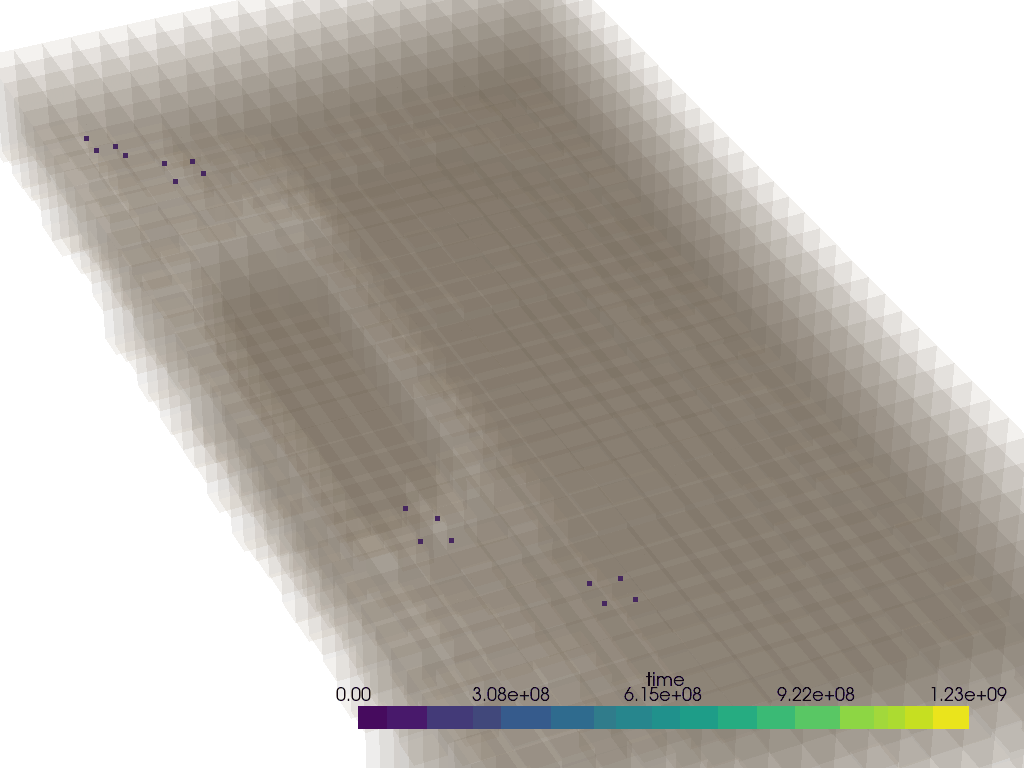

In [20]:
from IPython.core.display import Image

display(Image(data=open(gif_path,'rb').read(), format='png'))

Clean up the temporary workspace.

In [21]:
try:
    # ignore PermissionError on Windows
    temp_path.cleanup()
except:
    pass